# Analysis of the effect of blood vessel radius

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from pymcx import read_output_file, load_mcx_settings
from spectra import blood_mu_a, melanosome_mu_a, water_mu_a

matplotlib.rcParams['figure.figsize'] = (5,4)
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 18})

Load the list of parameters run and the files containing the output and settings files. The constant variables are removed for the summary tables.

In [2]:
parameters = pd.read_csv("params.csv", index_col=0)
# Simulations were run for a couple of different melanin concentrations.
parameters = parameters[parameters["Melanin"]==0.01]
parameters.loc[:, parameters.nunique()>1]

,VesselRadii,Wavelength,OutputFile,VolumeFile,SettingsFile
21,0.0005,7.000000e-07,result_0_1_00.mc2,volume_0.bin,settings_0_1_00.json
22,0.0005,7.100000e-07,result_0_1_01.mc2,volume_0.bin,settings_0_1_01.json
23,0.0005,7.200000e-07,result_0_1_02.mc2,volume_0.bin,settings_0_1_02.json
24,0.0005,7.300000e-07,result_0_1_03.mc2,volume_0.bin,settings_0_1_03.json
25,0.0005,7.400000e-07,result_0_1_04.mc2,volume_0.bin,settings_0_1_04.json
...,...,...,...,...,...
331,0.0040,8.600000e-07,result_7_1_16.mc2,volume_7.bin,settings_7_1_16.json
332,0.0040,8.700000e-07,result_7_1_17.mc2,volume_7.bin,settings_7_1_17.json
333,0.0040,8.800000e-07,result_7_1_18.mc2,volume_7.bin,settings_7_1_18.json
334,0.0040,8.900000e-07,result_7_1_19.mc2,volume_7.bin,settings_7_1_19.json


In [3]:
# View the phantom
settings = parameters["SettingsFile"].iloc[0]
volfile = parameters["VolumeFile"].iloc[0]

# Load the phantom settings.
mcx_settings = load_mcx_settings(settings)
dimension = tuple(mcx_settings["Domain"]["Dim"])
volume_numbered = []
for volfile in parameters["VolumeFile"].unique():
    volume = np.fromfile(volfile, dtype="uint8").reshape(dimension + (-1,), order="F")
    # Visualise the computational phantom.
    cmap = matplotlib.colors.ListedColormap([(1,1,1), (163/255, 113/255, 38/255), (1, 0.95, 0.95), (1,0,0)])
    #plt.imshow(volume[:, 100, :, 0].T, cmap=cmap)
    #plt.axis("off")
    #plt.show()
    volume_numbered.append(volume[:, 100, :, 0])

# Labels for each region.
regions = ["Outside", "Coupling Layer", "Epidermis", "Background", "Vessel"]

Load the simulated results, convert to a two-dimensional slice.

In [4]:
ms_results = []
# Define in the independent variable which is varied in the experiment.
variable = "VesselRadii"
labels = parameters[variable].unique()
for dep_variable in labels:
    selection = parameters[parameters[variable] == dep_variable]
    test = np.zeros((200, 200, 21), order="F")
    for i, (result_file, settings_file) in enumerate(zip(selection["OutputFile"], selection["SettingsFile"])):
        settings = load_mcx_settings(settings_file)
        result = read_output_file(result_file, settings)
        test[:, :, i] = np.sum(result[:, 90:110, :, 0], axis=1)
        # test[:, :, i] = result[:, 100, :, 0]
    ms_results.append(test)

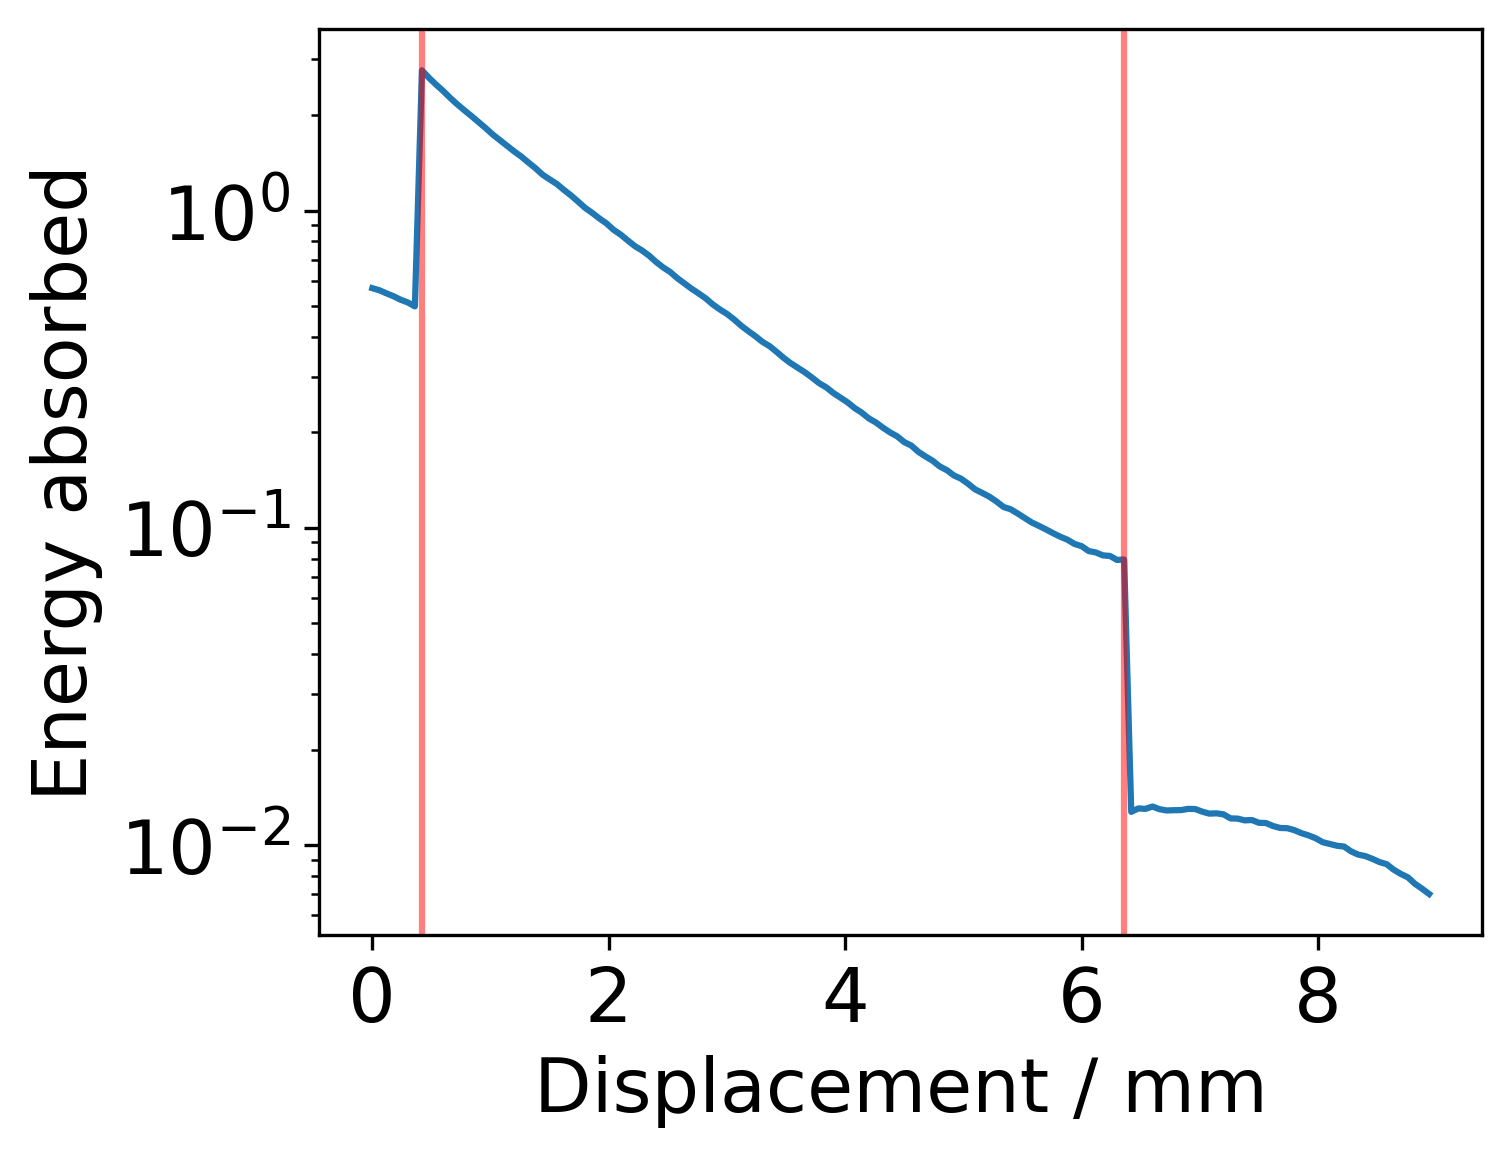

In [5]:
n = 5
absorption = np.sum(ms_results[n], axis=2)[100, 50:200]/10000
pixel_width = 0.06
x = np.arange(absorption.shape[0])*pixel_width
plt.semilogy(x,absorption)
plt.ylabel("Energy absorbed")
plt.xlabel("Displacement / mm")
plt.axvline(7*pixel_width, color="r",alpha=0.5)
plt.axvline(106*pixel_width, color="r", alpha=0.5)
plt.savefig("../FiguresOutput/exponential_decay.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Total energy absorption over the blood vessel averaged over wavelength

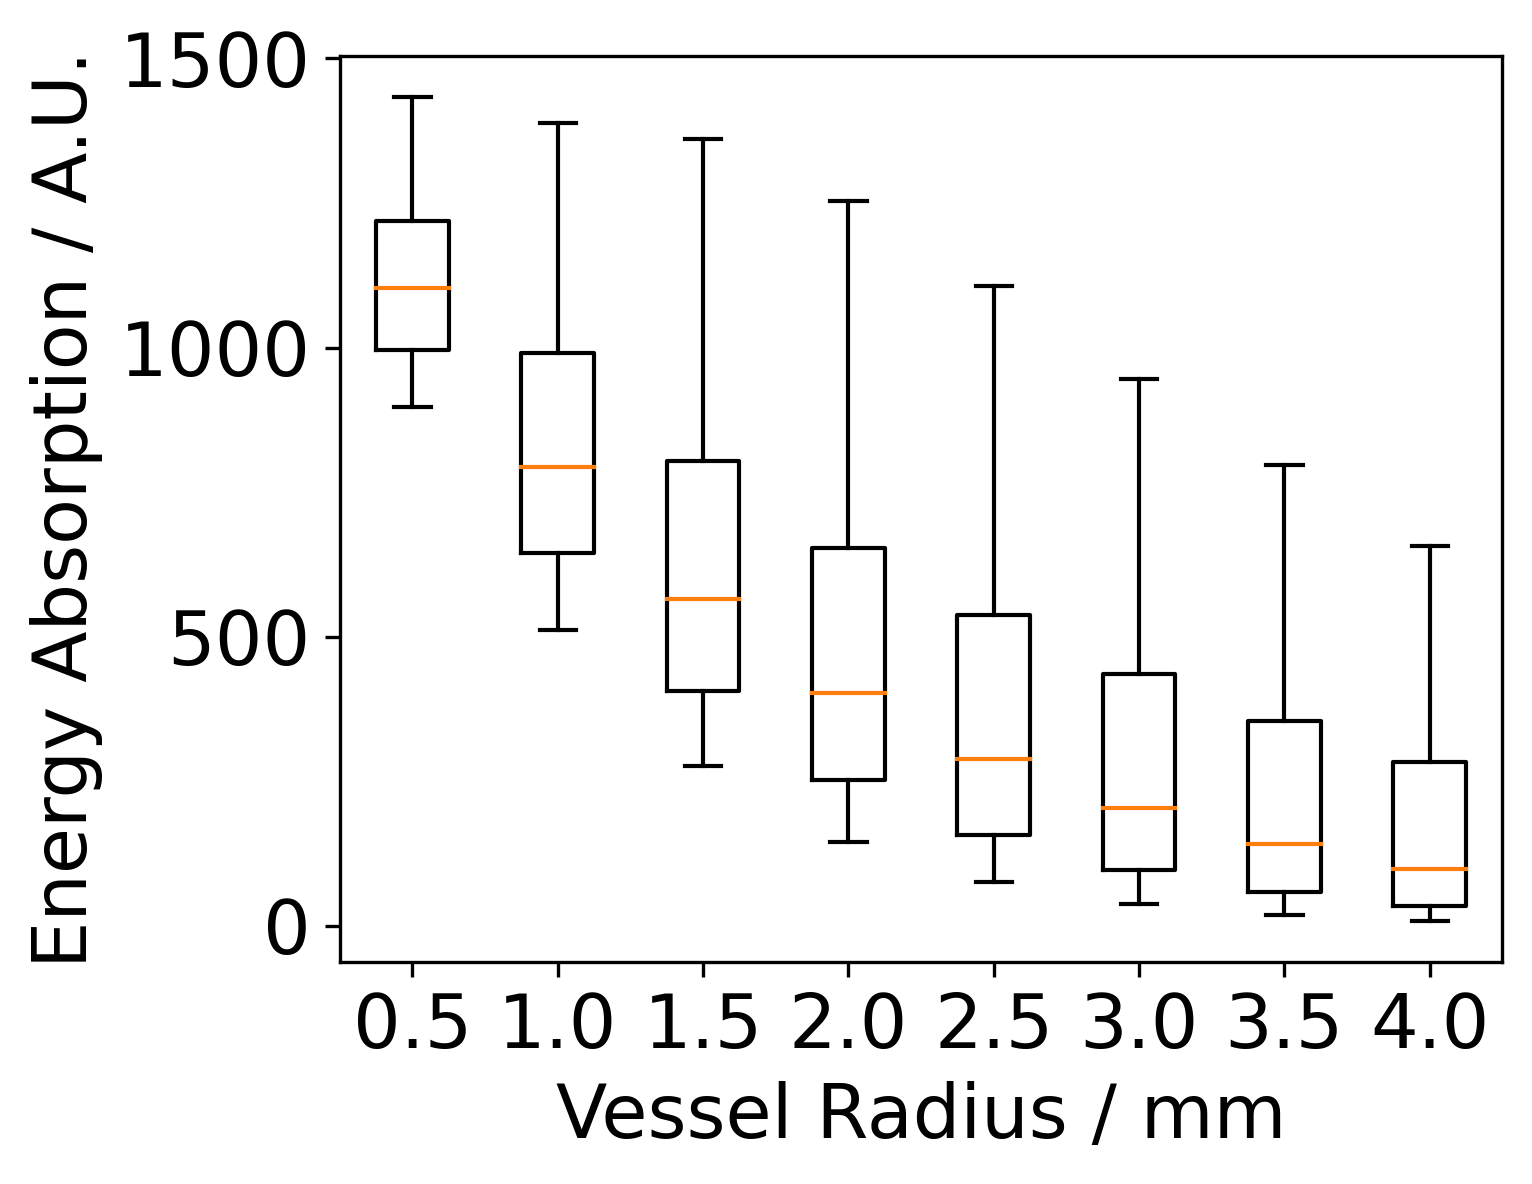

In [6]:
plt.boxplot([np.mean(s[volume_numbered[i] == 4], axis=1) for i, s in enumerate(ms_results)], showfliers=False, labels=labels*1e3)
plt.xlabel(r"Vessel Radius / mm")
plt.ylabel("Energy Absorption / A.U.")
plt.show()

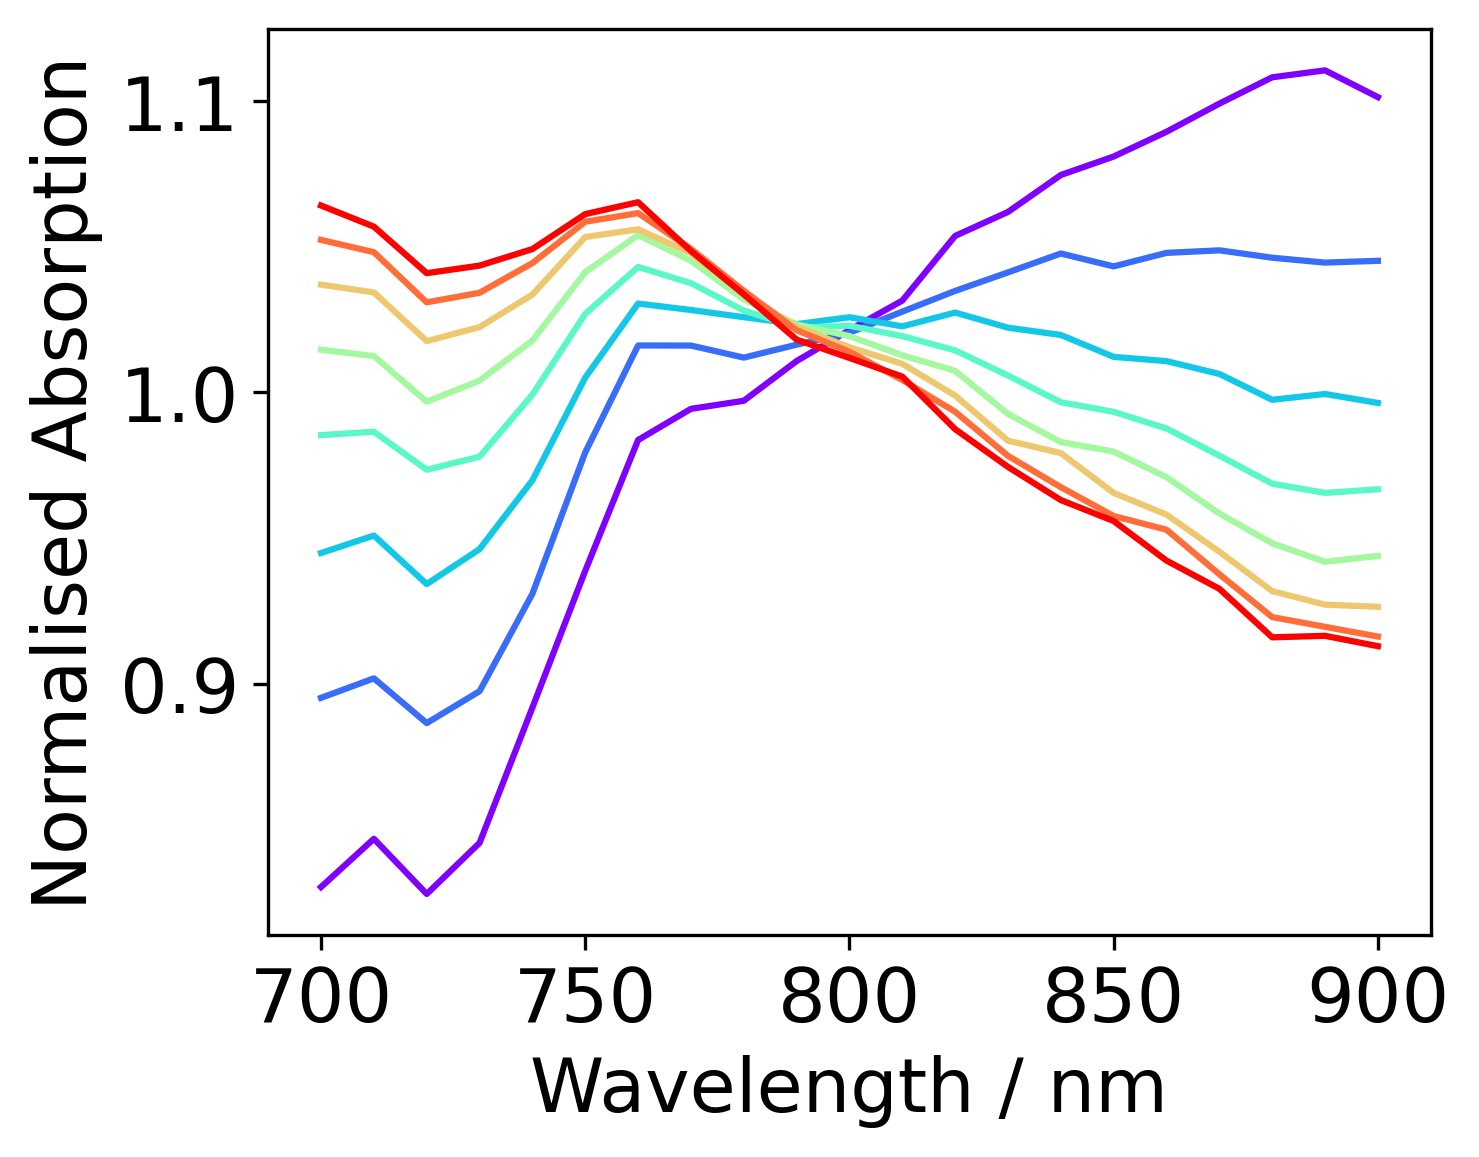

In [7]:
# Calculate the mean absorption spectra over the entire blood vessel over the independent variable.
mean_specs = [np.mean(result[volume_numbered[i] == 4], axis=0) for i, result in enumerate(ms_results)]

evenly_spaced_interval = np.linspace(0, 1, len(mean_specs))
line_colors = [matplotlib.cm.rainbow(x) for x in evenly_spaced_interval]

wavelengths = parameters["Wavelength"].unique()
for spec, label, color in zip(mean_specs, labels, line_colors):
    plt.plot(1e9*wavelengths, spec/np.mean(spec), label=label, color=color)

plt.xlabel("Wavelength / nm")
plt.ylabel("Normalised Absorption")
plt.savefig("../FiguresOutput/radius_abs_spec.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Spectral Unmixing

In [8]:
# Load the basis spectra
hb = blood_mu_a(wavelengths, 0, water = False)
hbo2 = blood_mu_a(wavelengths, 1, water = False)
water = water_mu_a(wavelengths)
melanin = melanosome_mu_a(wavelengths)
test = np.ones_like(wavelengths)

# Calculate the forward and (pseudo)-inverse matrices
spectra_matrix = np.array([hb, hbo2, water, melanin]).T
inv_matrix = np.linalg.pinv(spectra_matrix)

# Apply the unmixing matrix
unmixed = [np.dot(result, inv_matrix.T) for result in ms_results]
so2 = [M[:, :, 1]/(M[:, :, 1] + M[:, :, 0]) for M in unmixed]
THb = [M[:, :, 1]+M[:, :, 0] for M in unmixed]

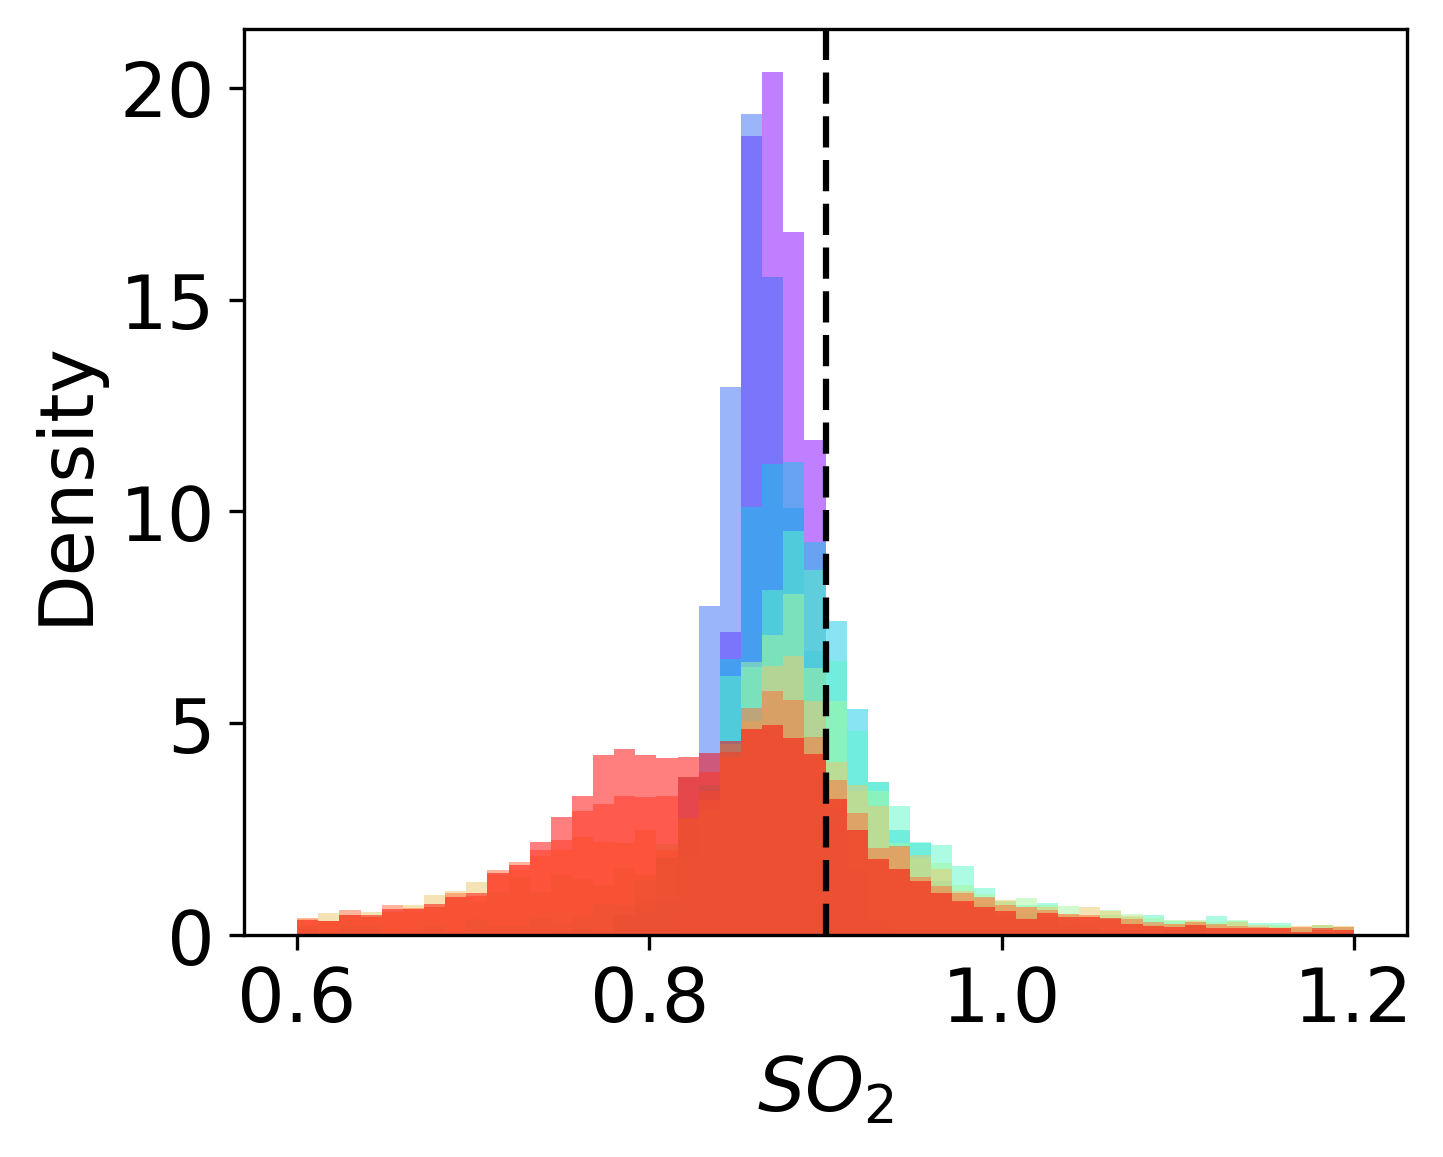

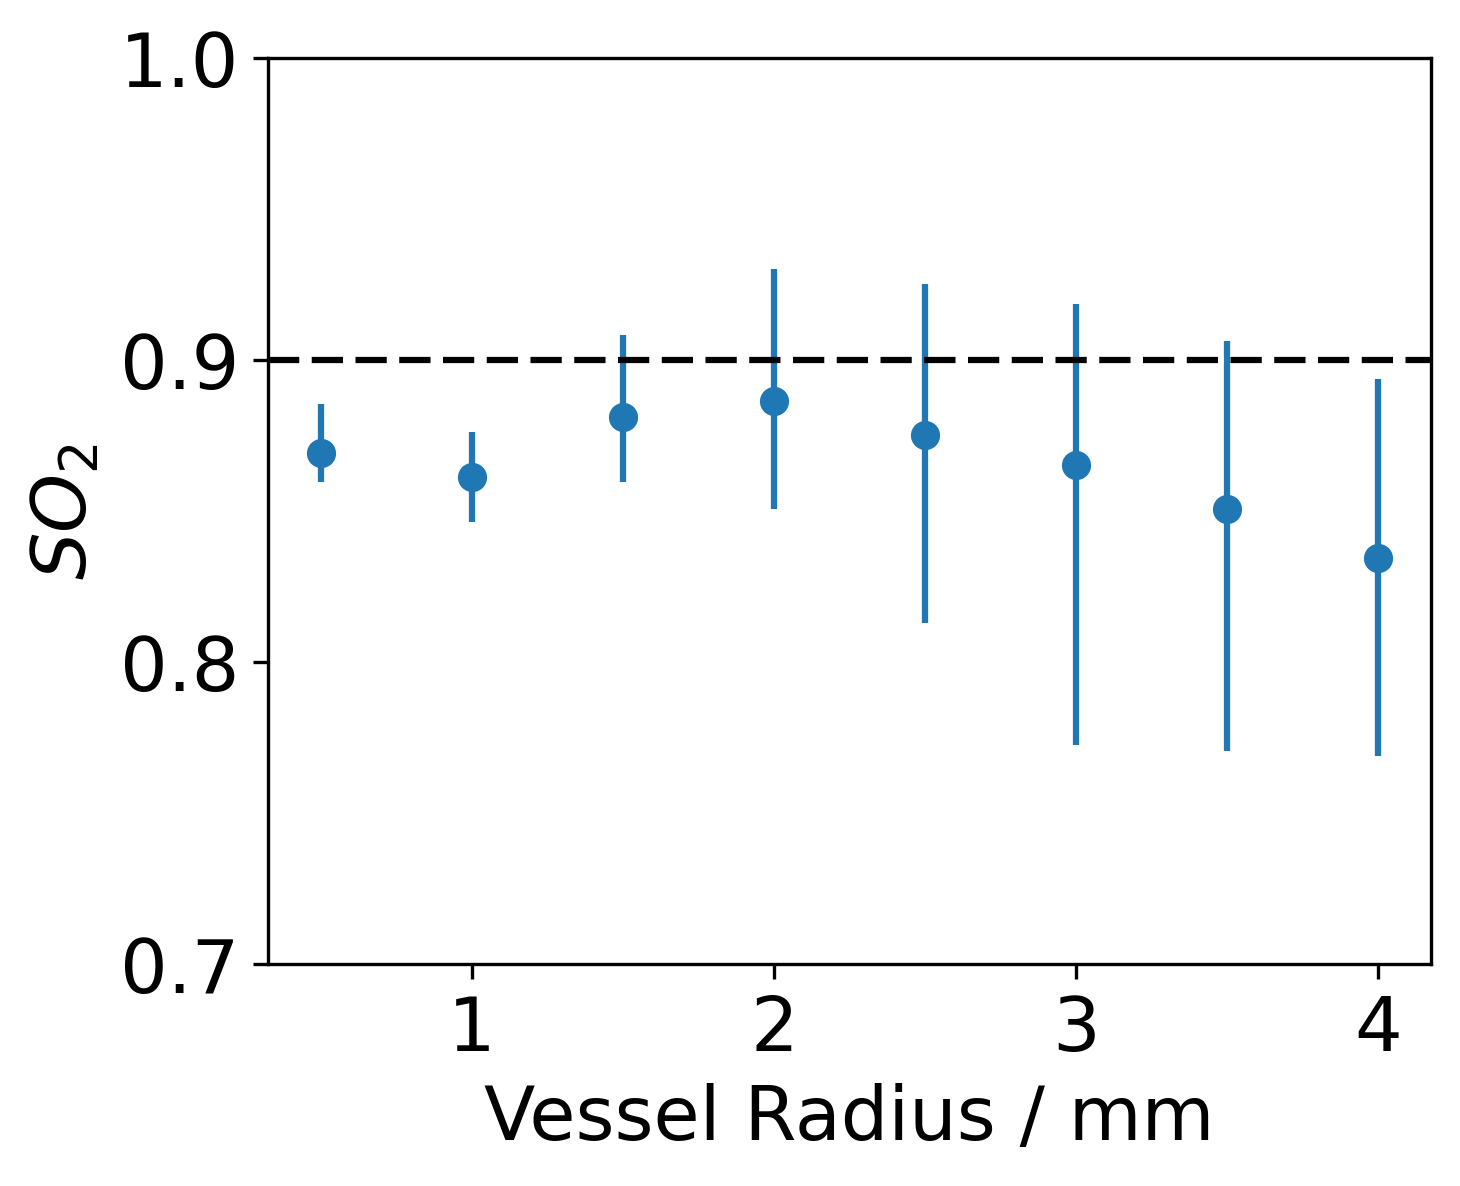

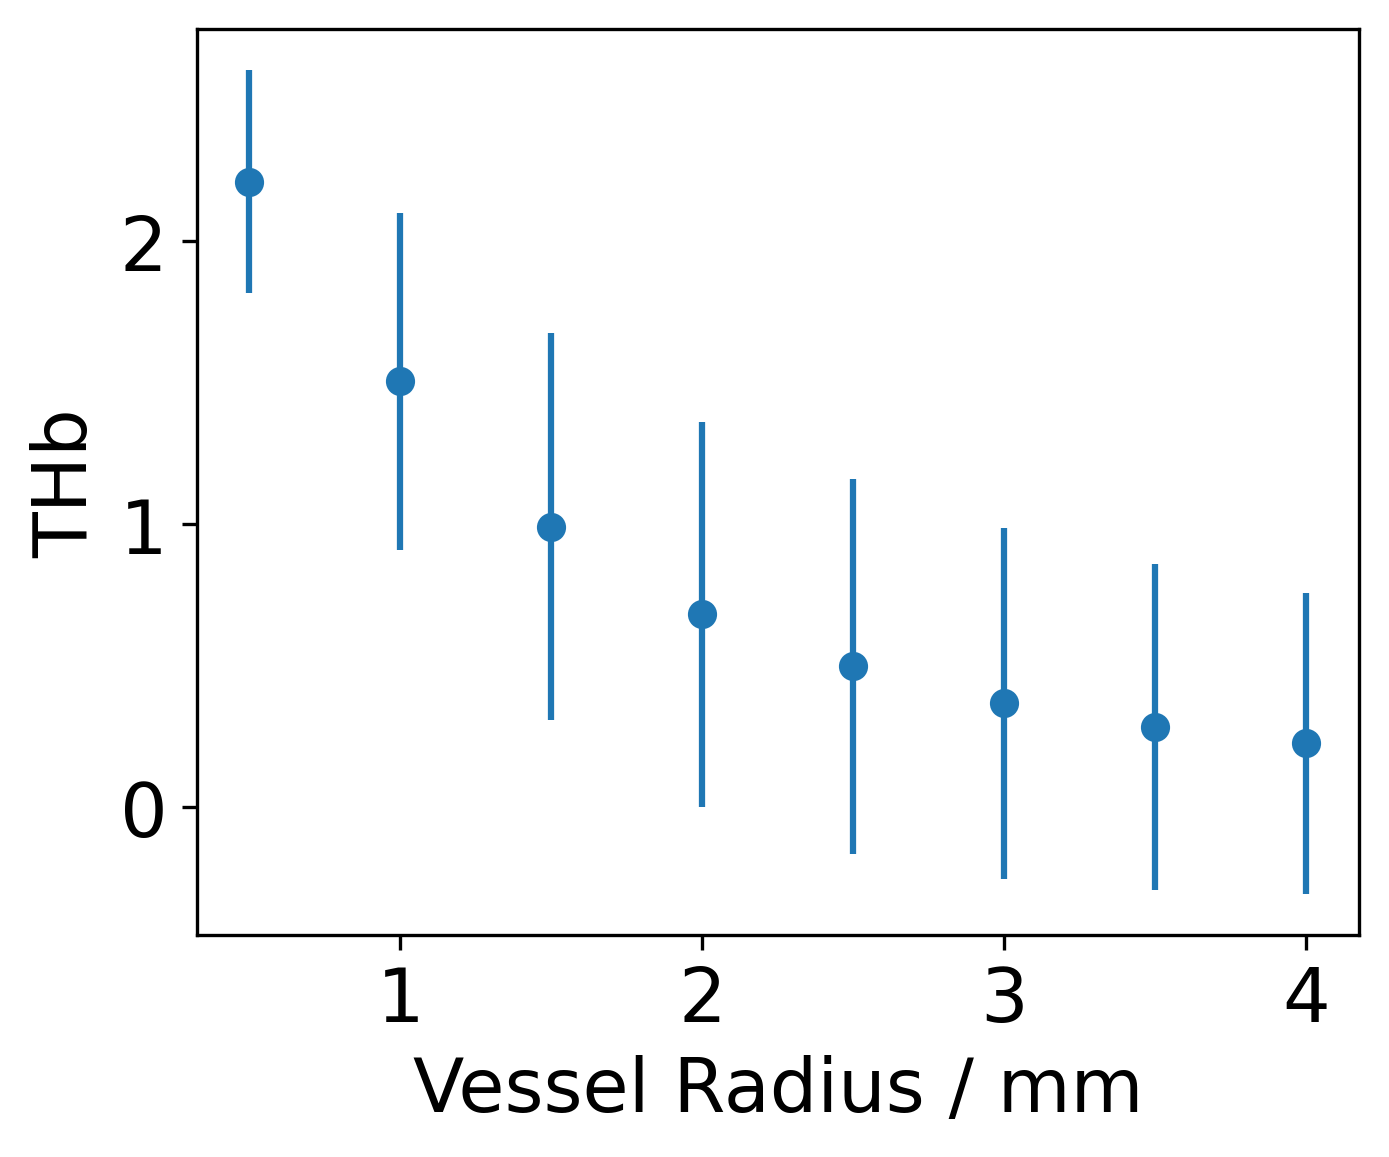

In [9]:
evenly_spaced_interval = np.linspace(0, 1, len(mean_specs))
line_colors = [matplotlib.cm.rainbow(x) for x in evenly_spaced_interval]

for i, (s, label, color) in enumerate(zip(so2, labels, line_colors)):
    plt.hist(s[volume_numbered[i] == 4], bins=50, range=(0.6,1.2), label=label, alpha=0.5,density=True, color = color)
plt.xlabel("$SO_2$")
plt.ylabel("Density")
plt.axvline(0.9, c="k", dashes=(5,2))
plt.savefig("../FiguresOutput/radius_SO2_hist.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

so2s = [s[volume_numbered[i] == 4] for i, s in enumerate(so2)]
means = np.array(list(map(np.median, so2s)))
stds = np.abs(means[:, None] - np.array(list(map(lambda x:np.percentile(x,[25,75]), so2s))))

#plt.boxplot([s[volume_numbered[i] == 4] for i, s in enumerate(so2)], showfliers=False, labels=labels_um)
plt.errorbar(labels*1e3, means, yerr=stds.T, fmt="o")
plt.xlabel(r"Vessel Radius / mm")
plt.ylabel("$SO_2$")
plt.ylim([0.7,1])
plt.axhline(0.9, c="k", dashes=(5,2))
plt.savefig("../FiguresOutput/radius_SO2.png", bbox_inches = 'tight', pad_inches = 0)

plt.show()

so2s = [s[volume_numbered[i] == 4] for i, s in enumerate(THb)]
means = np.array(list(map(np.mean, so2s)))
stds = np.array(list(map(np.std, so2s)))

#plt.boxplot([s[volume_numbered[i] == 4] for i, s in enumerate(so2)], showfliers=False, labels=labels_um)
plt.errorbar(labels*1e3, means, yerr=stds.T, fmt="o")
plt.xlabel(r"Vessel Radius / mm")
plt.ylabel("THb")
plt.savefig("../FiguresOutput/radius_THb.png", bbox_inches = 'tight', pad_inches = 0)

plt.show()

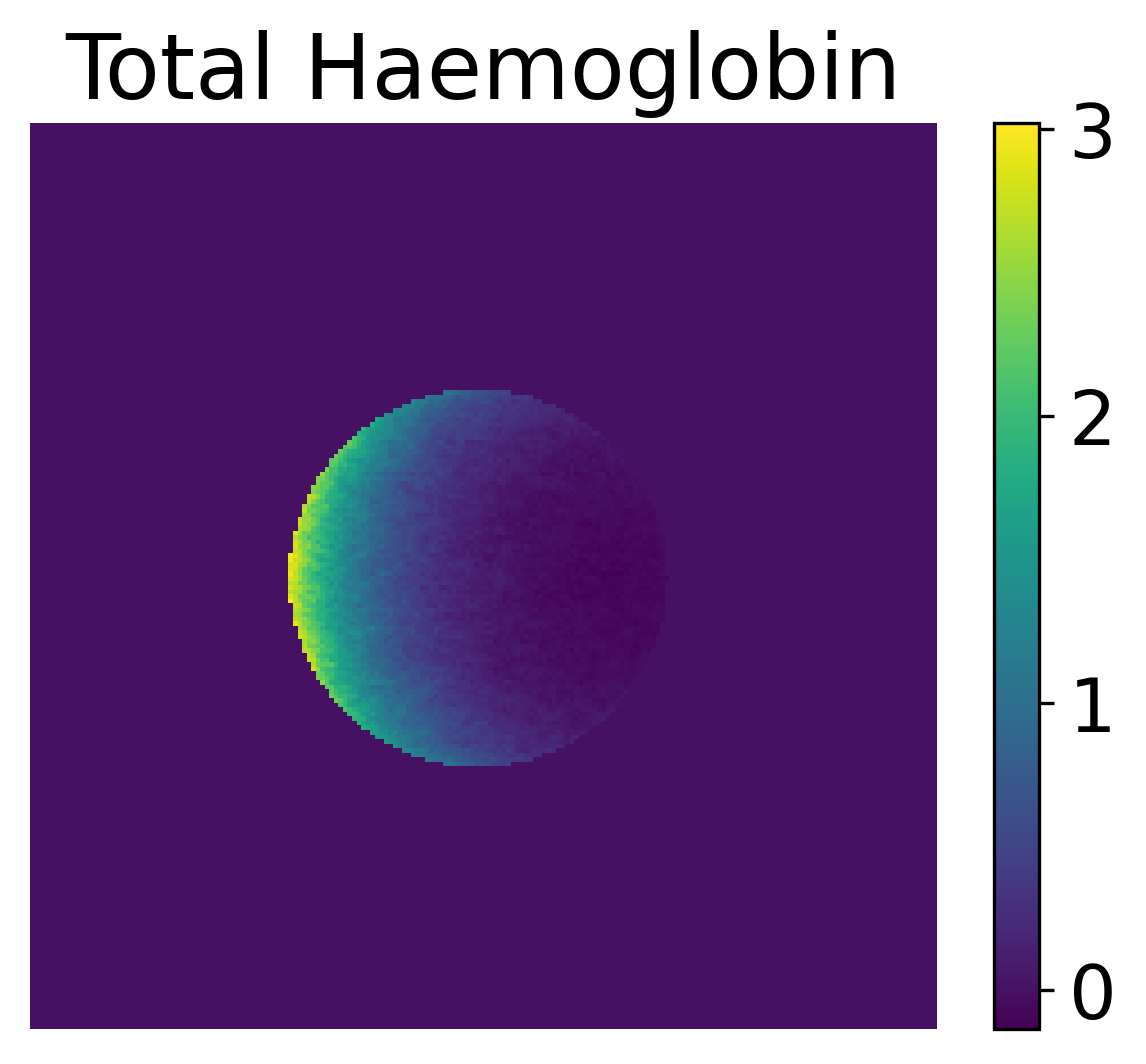

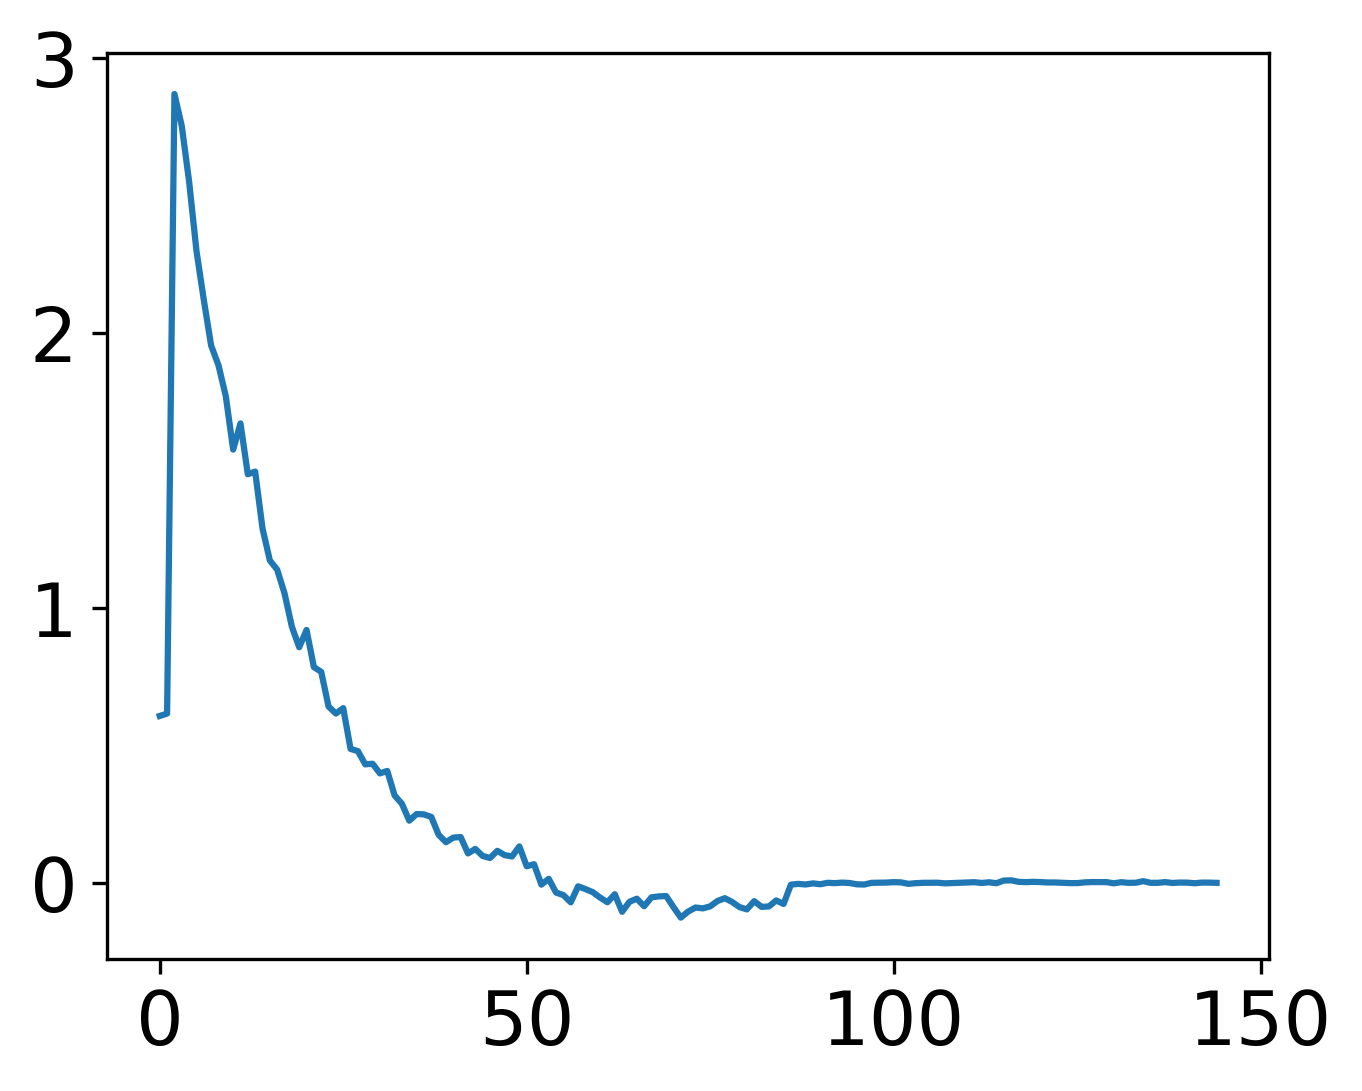

In [10]:
n=4
plt.imshow(THb[n] * (volume_numbered[n]==4))
plt.colorbar()
plt.axis("off")
plt.title("Total Haemoglobin")
plt.show()
plt.plot(THb[n][100, 55:])
plt.show()

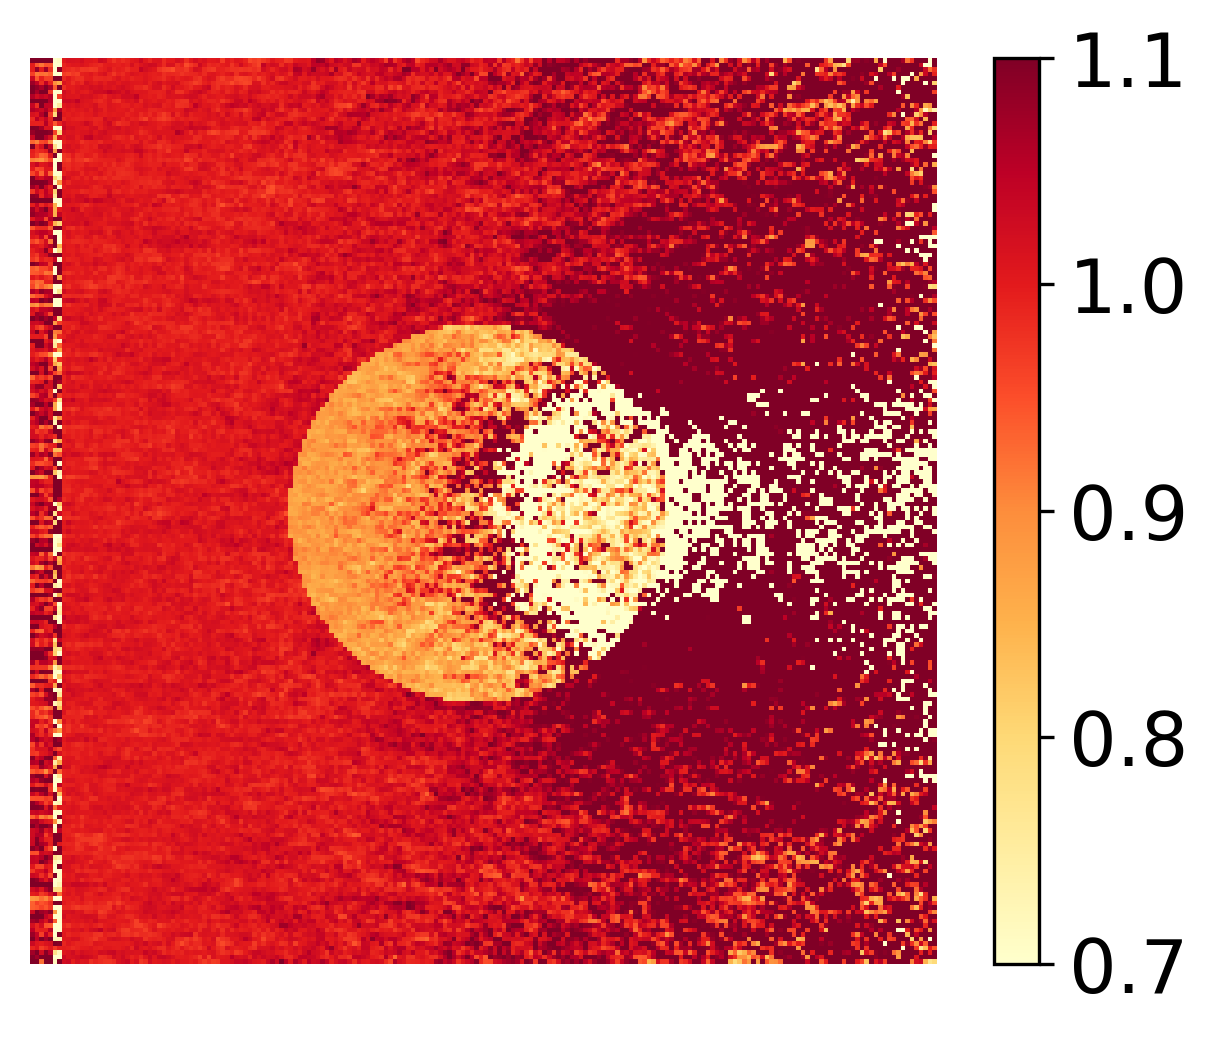

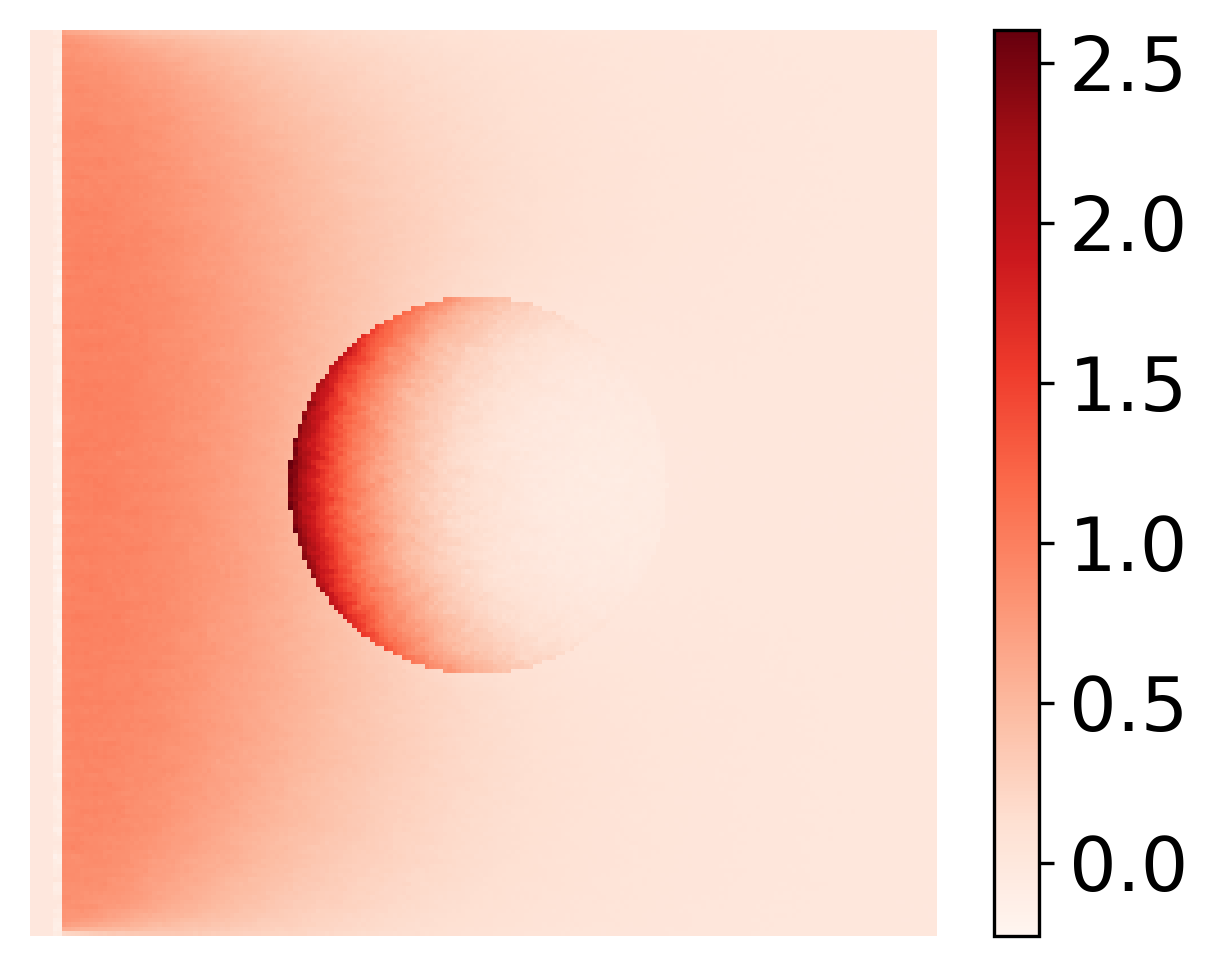

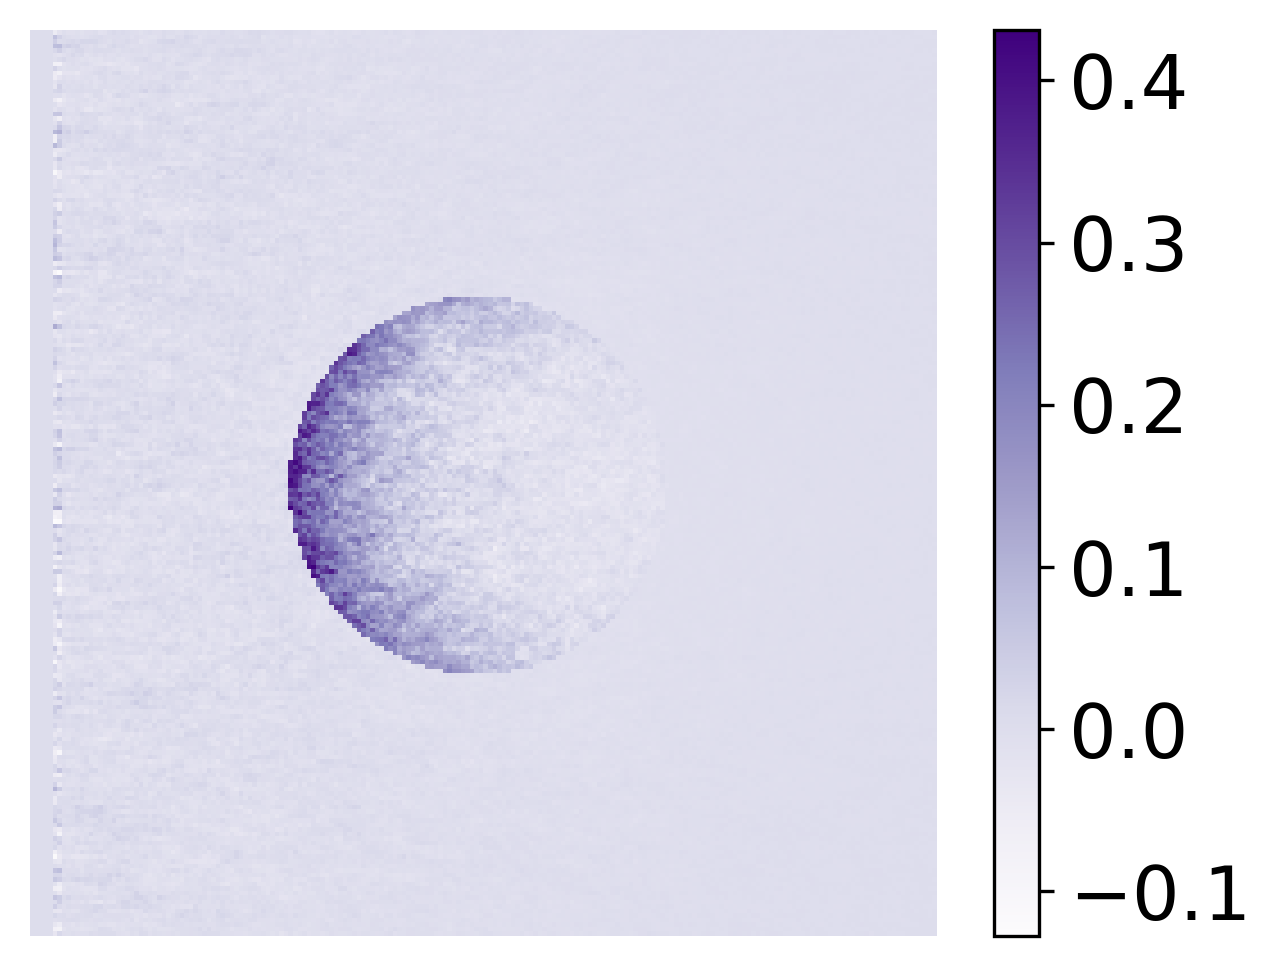

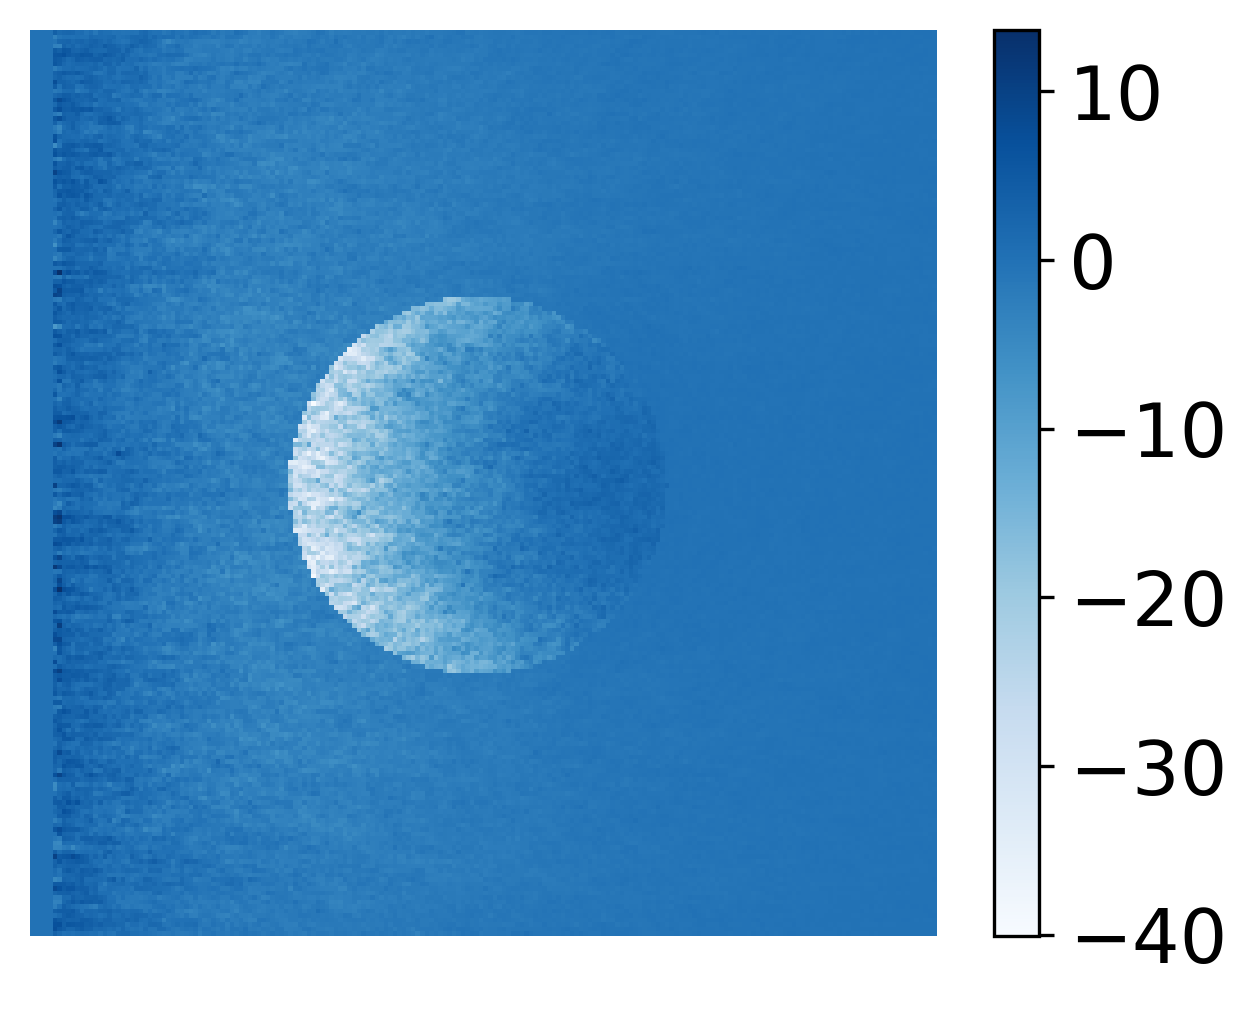

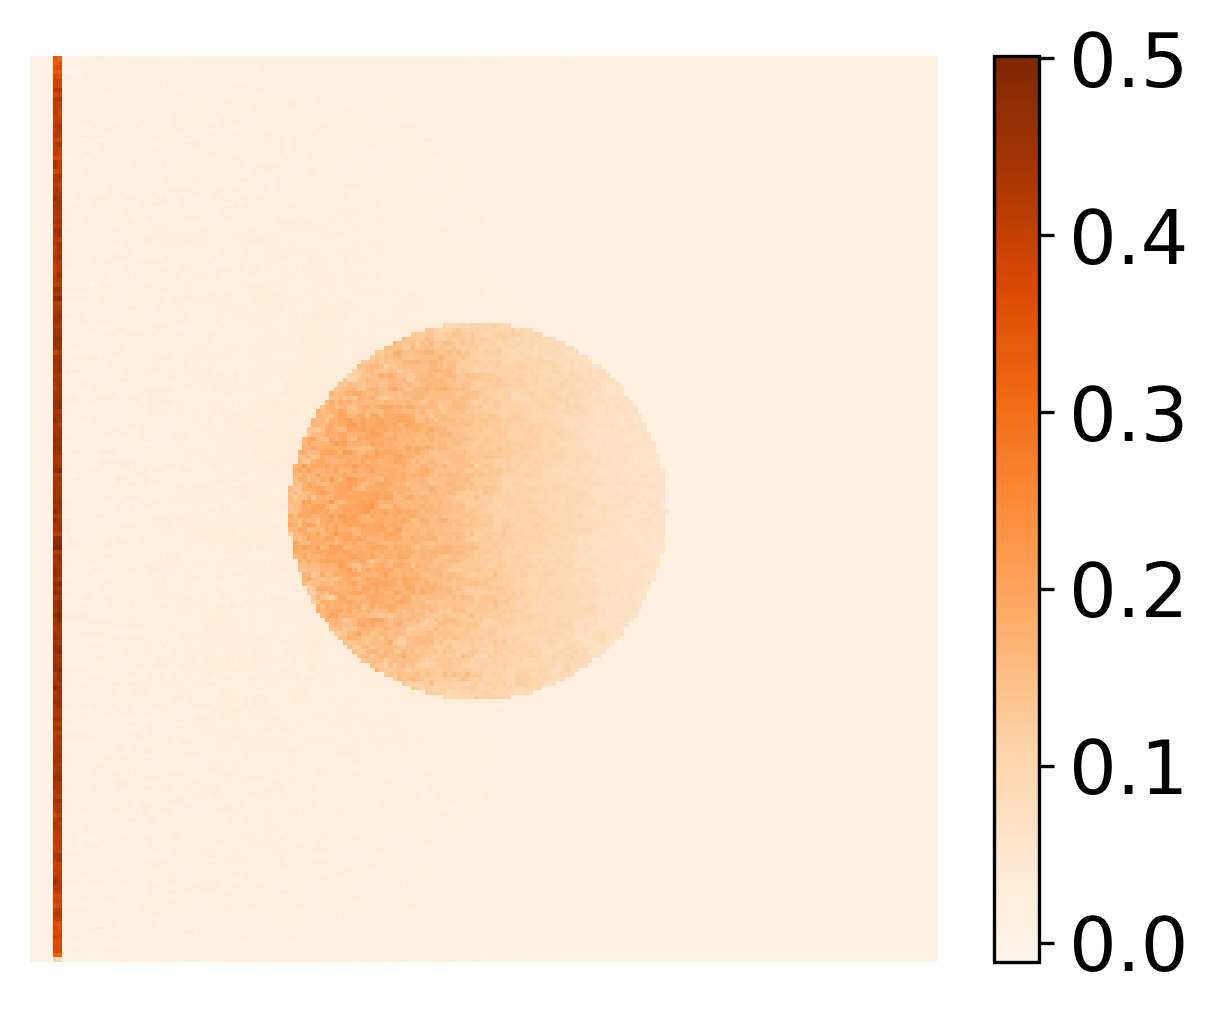

In [11]:
# SO2
plt.imshow(so2[n], cmap="YlOrRd", clim=(0.7,1.1))
plt.colorbar()
plt.axis("off")
plt.show()
# HbO2
plt.imshow(unmixed[n][:, :, 1], cmap="Reds")
plt.colorbar()
plt.axis("off")
plt.show()
# Hb
plt.imshow(unmixed[n][:, :, 0], cmap="Purples")
plt.colorbar()
plt.axis("off")
plt.show()
# Water
plt.imshow(unmixed[n][:, :, 2], cmap="Blues")
plt.colorbar()
plt.axis("off")
plt.show()
# Melanin
plt.imshow(unmixed[n][:, :, 3], cmap="Oranges")
plt.colorbar()
plt.axis("off")
plt.show()